<h1><center>Major League Baseball Pitch Classification </center></h1>

##1     Background

The best Major League Baseball pitchers have several different types of pitches in their arsenal. Baseball is a situational and strategic sport, so the idea is that having more pitches available keeps batters guessing and keeps them off-balance, which leads to more unsuccessful at-bats. Every single pitch is decided, before the throw, by the coach, catcher, and pitcher, as they consider factors such as the game situation, previous pitches thrown, batter history, and pitcher-hitter matchup, among others. Some of the most well-known pitch types are fastball, curveball, and changeup. Outside of the baseball community, some of the lesser-known pitch types are slider, splitter, and cutter. But how are these pitch types defined? Speed, location, and movement are the top three variables used to classify a pitch. However, none of these variables alone can completely determine a given pitch. Not to mention, different pitchers can make the same pitch type look different. (In fact, that is part of the pitcher's advantage.)

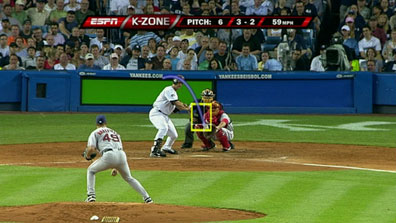

In [66]:
from IPython.display import Image
Image(filename='PitchfxExample.png')

*Public image provided by Sportvision*

The purpose of my machine learning project will be to classify pitches based on several features; the purpose of this data visualization project is to gain greater insight into the data that will be used to accomplish that task. Although it may be easy for someone familiar with the sport to physically see and identify which pitch has been thrown, it is still important for this task to be automated. The MLB records lots of data - just about every statistic imaginable, even down to player height differential for that given day of the year at that given ballpark. It is simply not practical to have someone sitting behind home plate at every game recording pitch location, break, speed, type, outcome, etc. For this reason, it is useful to have a pitch classifier that automates the process as measurements are taken electronically. The tool that produces the data I am using here most likely already has a tool to do this sort of problem. It is assumed that the creators use a machine learning algorithm to classify pitches based on their data. This classification problem has also been researched at several universities and independent baseball analysts, and good classifiers exist.

##2     Overview of the Data

The data that I am studying to solve the problem of pitch classification comes from Pitchf/x. Pitchf/x is a technology created by $Sportvision ^{(R)}$ and used by the MLB. Pitchf/x uses specialized cameras installed in all Major League ballparks to record highly specified measurements about every pitch. This is useful to players and coaches especially, but also provides fans with a more interactive experience. For example, Pitchf/x allows fans to see mapped-out trajectories of pitches on the TV screen (see the photo above). It is quickly revolutionizing the capture and use of pitching statistics in the big leagues. The Pitchf/x dataset I am using here captures essentially all variables related to pitching from the 2013, 2014, and 2015 MLB regular seasons.

I chose this dataset because the MLB's data comes from it as well, and it is trusted by MLB broadcasters. MLB.com holds this data and it is also used in the MLB apps, suggesting that it is trusted by Major League Baseball.

###2.1     Pitch Types

Pitchf/x uses 16 different pitch classifications. I created the table below to give a list of every pitch type along with their identifying abbreviation in the Pitchf/x dataset. In the "Creating the DataFrames" section of this report, I will simplify this list a bit.

Pitch Types


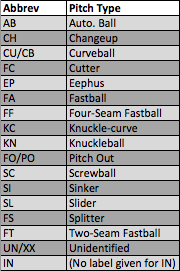

In [67]:
print "Pitch Types"
Image(filename='PitchTypeTable.png', width=200, height=200)

###2.2      Features

Several of the variables in the Pitchf/x dataset are defined in terms of the x, y, and z axes. So, before I discuss the features, I will describe the frame of reference from which measurements are taken. Pitchf/x has established a universal frame of reference, which allows results from different ballparks to be compared. The following graphic, taken from the Pitchf/x data glossary, decpits the frame of reference in which measurements are taken. Having this information will help make sense of the data described next. 

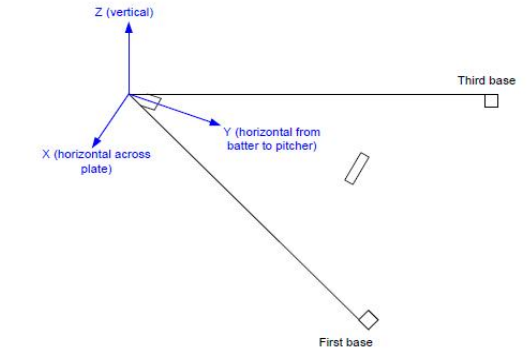

In [68]:
Image(filename='Axes.png', width=650, height=650)

I will now discuss the variables that will be used in my project. For now, I will ignore those that I will end up dropping because of irrelevance - this will be discussed in the next section. Each of the variables described here holds information for every pitch thrown in the 2013, 2014, and 2015 MLB regular seasons. 

####2.2.1    Speed

The *initial_speed* variable describes the speed of the ball (miles per hour) as it leaves the pitcher's hand. Similarly, *plate_speed* describes the speed of the ball (miles per hour) as it crosses home plate. In feet per second, as described from the catcher's perspective, *init_vel_x*, *init_vel_y*, and *init_vel_z* describe the velocities along the x, y, and z axes, respectively, at 50 feet from home plate.

####2.2.2    Position

The variables *bat_side* and *throws* identify handedness in the batter and pitcher, respectively. Consider that an inside pitch thrown to a lefty would be an outside pitch to a righty. Thus, two pitches with the same location can by very different in terms of what the batter sees, and will often result in different classifications. When the ball is about to be released by the pitcher, *init_pos_x* gives the horizontal location of the ball at the mound, and *init_pos_z* gives the ball height at the mound. These are both measured in feet. The variable *init_pos_y* is always 50 feet. The variable *plate_x* describes the horizontal location of the ball from the center of home plate, and *plate_z* describes the height of the ball above the ground at home plate. These are again determined from the catcher's perspective.

####2.2.3     Movement

Movement describes how the ball travels while it is in the air. For example, curveballs typically move more than fastballs. A pitch that comes in a straight line from the mound to the plate can be described as having no movement. These next few variables describe the movement of a pitch. Acceleration along the x-, y-, and z- axes is given respectively by *init_accel_x*, *init_accel_y*, and *init_accel_z*. These are measured in feet per second from the catcher's perspective. The variables *break_x* and *break_z* give the horizontal and vertical movement of the ball, respectively, and are measured in inches.

##3     Creating the DataFrame

In [69]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

In [70]:
#load data from csv to pandas dataframe
pitchDF = pd.DataFrame.from_csv('drive-download-20161204T080739Z/Pitchfx.csv')

The following table describes the pitches in the dataset. There are 2,114,259 observations (pitches/rows) and 18 unique classifications. This was immediately concerning because the Pitchf/x glossary has 17 classifications identifying 15 pitches. I will address this issue further in Section 3.1 when I describe how I cleaned the data.

In [71]:
#get summary statistics for pitch types
pitchDF[['pitch_type']].describe()

,pitch_type
count,2114259
unique,18
top,FF
freq,742398


###3.1   Cleaning the Data

The Pitchf/x data holds a lot more variables than what is needed here, so I dropped several of the irrelevant columns. These included game date, game ID, pitch ID, at bat and pitch numbers, inning, outcome of the pitch, which team was batting, information from previous pitches, pitcher ID, batter ID, and situational information. I decided not to include these variables because I eventually want my classifier to work independent of this data. For instance, if I just threw a pitch for fun out on the field, I would want it to be able to classify that pitch. I do not want the classifier to take into account whether or not the first pitch of the game is typically a fastball, or whether or not Clayton Kershaw throws more curveballs with Buster Posey on first base. It should just take the speed and trajectory information of the pitch and be able to classify it based on those features. The following code drops the columns I deemed irrelevant or unnecessary.

In [72]:
#drop unnecessary columns from the dataframe
pitchDF.drop(['game_id', 'game_date', 'year', 'sv_pitch_id', 'at_bat_number', 'pitch_number', \
             'inning', 'top_inning_sw', 'event_type', 'event_result', 'pre_balls', 'pre_strikes', 'pre_outs', \
             'batter_id', 'pitcher_id', 'HitTrajectory', 'PlaybyPlay', 'Runneron1st_ID', \
             'Runneron2nd_ID', 'Runneron3rd_ID'], axis=1, inplace=True)

As shown in the Pitch Types table in Section 2.1, some pitch types have been assigned two different abbreviations. For example, a pitch out is denoted FO or PO, a curveball is denoted CU or CB, and unidentified is denoted UN or XX. I needed every individual pitch type to have its own unique identifier, so I replaced all CU's with CB's, all XX's with UN's, and all FO's with PO's. There were also 238 NaN occurrences, so I dropped those rows from my dataset because 238 is relatively small compared to the 2 million plus rows that I had. There was also a pitch classification that showed up in the data without any explanation: IN. There were about 9,500 of these, and after extensive research I could not justify it as an error or determine which pitch type IN was intended to represent. Therefore, I decided to convert IN's to UN's (unidentified). Lastly, there were approximately 200 pitches classified as FA, but in reality any FA pitch is either an FF, FT, or SI pitch. Most commonly, if not classified as FF or FT, the fastball (FA) is a sinker (SI). For that reason, I replaced all FA occurrences with SI. The following code accomplishes these tasks.

In [73]:
#drop rows where any data is missing
pitchDF = pitchDF.dropna(axis=0)
#replace first list variables with second list to avoid duplicates and correct misclassifications
pitchDF = pitchDF.replace(to_replace = ['CU','XX','FO', 'IN', 'FA'], value = ['CB','UN','PO', 'UN', 'SI'])

##4     Visualization

After the data was cleaned and prepared for analysis, I visually explored it. I will now go through my analysis and visualizations. This will include mostly tables and plots, generated using the Pandas and Matplotlib Python libraries.

###4.1 Frequencies

First, I looked at the total number of pitches in the dataset and the number of each specific type of pitch. See the graph "Pitch Frequencies" below. This allowed me to gain some intuition about which pitches were most common and to see if there were enough of each type to include in my project. (For example, if only 50 eephus pitches were thrown over the 3 seasons, this would average out to about 16 eephus pitches per season. Considering that there are 2,430 games played per season, this number would be negligible. If that were the case, I might have considered not including it as a potential classification.)

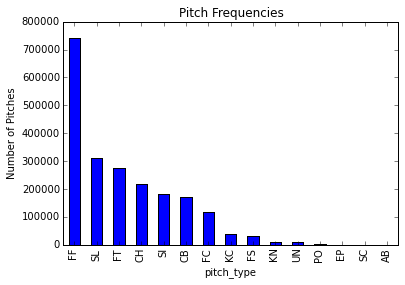

In [74]:
#create a bar plot with the counts of each type of pitch
pitchDF.pitch_type.value_counts().plot(kind='bar', title = 'Pitch Frequencies')
plt.xlabel("pitch_type")
plt.ylabel("Number of Pitches")
plt.show()

 After noticing that the 6 lowest-frequency pitches were difficult to see on the initial plot, I plotted those pitch types separately. See the graph "Frequencies of Pitches Thrown Less Often" below. Consequently, the scales are very different and this is important to notice when comparing the results.

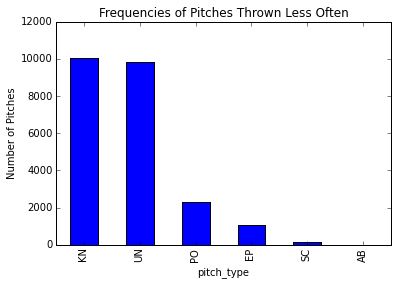

In [75]:
#create a list of 6 pitches thrown least often
sm_freq_pitches = ['KN', 'UN', 'PO', 'EP', 'SC', 'AB']
#create a bar plot with counts of each type of pitch that is thrown less often
pitchDF.pitch_type[pitchDF.pitch_type.isin(sm_freq_pitches)].value_counts().plot(kind='bar', \
                title='Frequencies of Pitches Thrown Less Often')
plt.xlabel("pitch_type")
plt.ylabel("Number of Pitches")
plt.show()

In this last histogram, the pitch types AB and SC have incredibly low frequencies, around the 300 range or less. Out of over 2 million observations, I concluded that the AB and SC counts were too low to include. I also did not want my classifier to classify pitches as "Unidentified" (UN). For those reasons, I decided to drop all rows that have pitch types UN or AB as an additional cleaning step. The following code accomplishes these tasks.

In [76]:
#drop all pitches classified as UN, AB, or SC
pitchDF = pitchDF[(pitchDF['pitch_type'] != 'UN') & (pitchDF['pitch_type'] != 'AB') & (pitchDF['pitch_type'] != 'SC')]

A bar plot ommitting the dropped pitches is shown below (see "Pitch Frequencies (%)"). This new bar plot is also scaled to 1 so that pitch frequency is reported in terms of percentage of total pitches thrown. This gives a better idea of overall proportions.

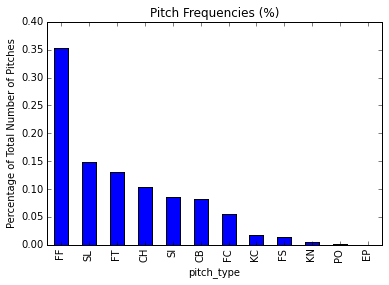

In [77]:
#create list of percentages
percentages = pitchDF.pitch_type.value_counts()/float(len(pitchDF))
#plot each pitch with percentage frequency
percentages.plot(kind='bar', title = 'Pitch Frequencies (%)')
plt.xlabel("pitch_type")
plt.ylabel("Percentage of Total Number of Pitches")
plt.show()

###4.2 Speed

One of the most obvious things to look at when comparing pitches is the speed. MLB pitchers average 80 miles per hour (mph) when throwing changeups; their fastballs average 90 mph; their eephus pitches average just 66 mph. The *initial_speed* variable best describes the speed of the ball in terms of what a radar gun usually picks up, and this is what fans are used to seeing reported as pitch speed. This is why I decided to use *initial_speed* rather than *plate_speed* to do speed comparisons. The following code produces average speeds for each pitch type and lists them in descending order. These results were as expected.

In [78]:
#create list of average speeds
average_speeds = []
for pitch in pitchDF['pitch_type'].unique():
    #calculate average speed for each pitch type
    average_speeds.append((pitch, pitchDF[pitchDF['pitch_type'] == pitch]['initial_speed'].mean())) 
for el in sorted(average_speeds, key = lambda x: -x[1]):
    print "{0}: {1:.2f} mph".format(el[0], el[1])

FF: 92.21 mph
FT: 91.54 mph
SI: 90.79 mph
FC: 88.08 mph
PO: 85.60 mph
FS: 83.99 mph
SL: 83.85 mph
CH: 83.20 mph
KC: 79.79 mph
CB: 77.30 mph
KN: 75.89 mph
EP: 66.28 mph


The similarity in speed for most pitches does not allow for good classification using speed alone. However, looking at speed differences still provides useful information. A classifier that is at least not terrible should be able to see based on speed that an eephus (EP) pitch is not a fastball (FF/FT/SI). Moving inward from both ends of the list above, however, those boundaries are blurred. More information is definitely needed.

Next, I compared *plate_speed* with *initial_speed* in hopes that the changing speed of the ball as it travels from the mound to the plate would be useful. The line of best fit in every case closely resembles $plate\_speed = initial\_speed - 5$. It makes sense, due to weather, pitcher strength, and other factors, that the ball speed decreases fairly uniformly as it reaches the batter. So, this doesn't give much new information, but it does give a new interesting way of visualizing the differences in speeds between pitch types.

The following scatter plots, "Initial Speed vs. Speed at Plate", show *initial_speed* vs. *plate_speed* for fastballs (FF), eephus pitches (EP), and knuckle-curves (KC). While KC's have some overlap with the other two pitches, the distinction between FF and EP is clearly reiterated. The second plot shows just FF's and EP's, which makes the distinction more clear.

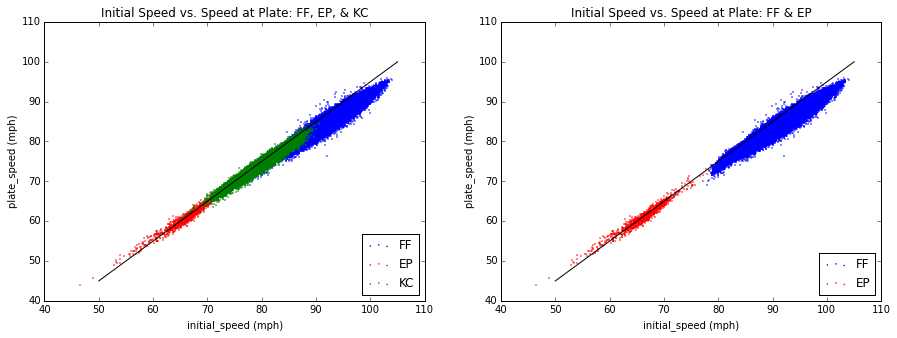

In [79]:
#scatter plot of speeds

#first subplot grahps FF, EP, & KC
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(pitchDF[pitchDF['pitch_type'] == 'FF']['initial_speed'].values, pitchDF[pitchDF['pitch_type'] == 'FF']\
            ['plate_speed'].values, s=0.3, color='blue', label = 'FF')
plt.scatter(pitchDF[pitchDF['pitch_type'] == 'EP']['initial_speed'].values, pitchDF[pitchDF['pitch_type'] == 'EP']\
            ['plate_speed'].values, s=0.3, color='red', label = 'EP')
plt.scatter(pitchDF[pitchDF['pitch_type'] == 'KC']['initial_speed'].values, pitchDF[pitchDF['pitch_type'] == 'KC']\
            ['plate_speed'].values, s=0.3, color='green', label = 'KC')
#graph the approximate line of best fit
x_vals_speed = np.linspace(50, 105, 200)
y_vals_speed = [x-5 for x in x_vals_speed]
plt.plot(x_vals_speed,y_vals_speed,color='black')
plt.title('Initial Speed vs. Speed at Plate: FF, EP, & KC')
plt.xlabel('initial_speed (mph)')
plt.ylabel('plate_speed (mph)')
plt.legend(loc=4)

#second subplot grahps FF & EP
plt.subplot(1,2,2)
plt.scatter(pitchDF[pitchDF['pitch_type'] == 'FF']['initial_speed'].values, pitchDF[pitchDF['pitch_type'] == 'FF']\
            ['plate_speed'].values, s=0.3, color='blue', label = 'FF')
plt.scatter(pitchDF[pitchDF['pitch_type'] == 'EP']['initial_speed'].values, pitchDF[pitchDF['pitch_type'] == 'EP']\
            ['plate_speed'].values, s=0.3, color='red', label = 'EP')
plt.plot(x_vals_speed,y_vals_speed,color='black')
plt.title('Initial Speed vs. Speed at Plate: FF & EP')
plt.xlabel('initial_speed (mph)')
plt.ylabel('plate_speed (mph)')
plt.legend(loc=4)
plt.show()

While on the topic of speed, I decided to compare speed against some of the other variables. The first graph is a hexbin plot comparing *break_x* with *initial_speed* for fastballs (FF), and the second does the same for curveballs (CB). Interestingly, the distributions appear to sort of resemble a double Gaussian. This sort of shows the distinction between pitching to righties and to lefties. More density appears on one side in each case presumably because there are more right-handed batters in the MLB. It will help in classification that FF has more density to the left, while CB has more to the right. It is also worth noting that lefties have a higher batting average than righties across the MLB, so maybe pitchers aren't as likely to give lefties their perfect pitch. See "Break in x vs. Initial Speed" below.

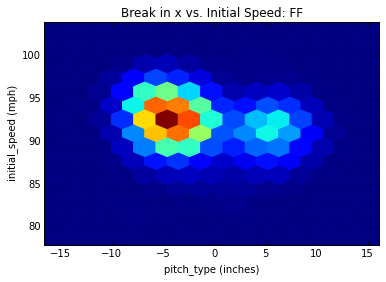

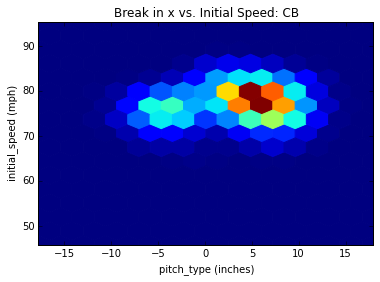

In [80]:
#plt.figure(figsize=(13,6))
#plt.subplot(1,2,1)
plt.hexbin(pitchDF[pitchDF['pitch_type'] == 'FF']['break_x'].values, pitchDF[pitchDF['pitch_type'] == 'FF']\
           ['initial_speed'].values, gridsize=15)
plt.ylabel('initial_speed (mph)')
plt.xlabel('pitch_type (inches)')
plt.title('Break in x vs. Initial Speed: FF')
plt.show()

#plt.subplot(1,2,2)
plt.hexbin(pitchDF[pitchDF['pitch_type'] == 'CB']['break_x'].values, pitchDF[pitchDF['pitch_type'] == 'CB']\
           ['initial_speed'].values, gridsize=15)
plt.ylabel('initial_speed (mph)')
plt.xlabel('pitch_type (inches)')
plt.title('Break in x vs. Initial Speed: CB')
plt.show()

###4.3    Location

The following scatter plots, see "Position at Home Plate", show comparisons between pitch types in terms of the ball position as it crosses home plate. Pitch outs (PO) and eephus pitches (EP) are distinctly different in certain areas of the plot. These two pitch types are very different from each other, and the scatter plot shows that. I plotted FF's first, simply because the volume is larger than EP's, and this prevents the EP data points from being hidden. While not all PO's are high and outside, about half of them are. This fact alone seems to distinguish them from four-seam fastballs. Three groupings of PO's are evident, and the symmetry is not surprising if batter handedness is considered. Many PO's are thrown high and outside to the batter; it is an intentional ball.

The second scatter plot compares changeups (CH) and curveballs (CB). These two are much more similar, which makes sense because a pitcher usually tries to throw changeups and curveballs into the strike zone. There is a lot of overlap - switching the order in which the points appear gives no useful information. As compared to the FF/PO plot, this is not particularly useful in terms of pitch classification. This is mainly included to show contrast between the information gained from the first comparison and the (lack of) information gained from the second comparison.

Note also that these graphs are mostly symmetric about the line $x=0$, which makes sense when accounting for batter handedness.

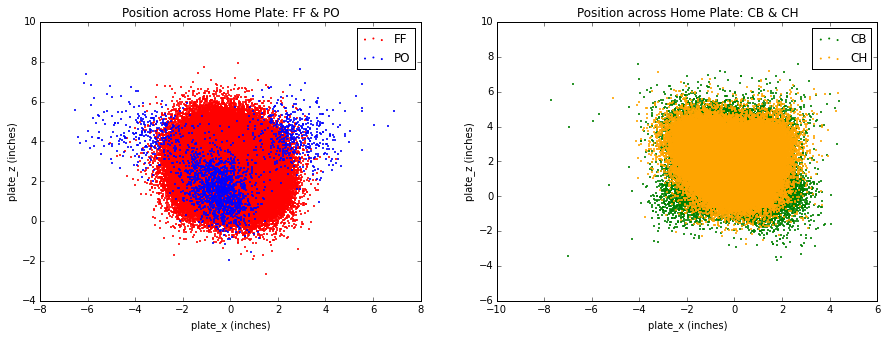

In [81]:
#scatter plot of locations

#first subplot graphs FF & PO
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(pitchDF[pitchDF['pitch_type'] == 'FF']['plate_x'].values, pitchDF[pitchDF['pitch_type'] == 'FF']\
            ['plate_z'].values, s=1, color='red', label = 'FF')
plt.scatter(pitchDF[pitchDF['pitch_type'] == 'PO']['plate_x'].values, pitchDF[pitchDF['pitch_type'] == 'PO']\
            ['plate_z'].values, s=1, color='blue', label = 'PO')
plt.title('Position across Home Plate: FF & PO')
plt.xlabel('plate_x (inches)')
plt.ylabel('plate_z (inches)')
plt.legend()

#second subplot graphs CH & CB
plt.subplot(1,2,2)
plt.scatter(pitchDF[pitchDF['pitch_type'] == 'CB']['plate_x'].values, pitchDF[pitchDF['pitch_type'] == 'CB']\
            ['plate_z'].values, s=1, color='green', label = 'CB')
plt.scatter(pitchDF[pitchDF['pitch_type'] == 'CH']['plate_x'].values, pitchDF[pitchDF['pitch_type'] == 'CH']\
            ['plate_z'].values, s=1, color='orange', label = 'CH')
plt.title('Position across Home Plate: CB & CH')
plt.xlabel('plate_x (inches)')
plt.ylabel('plate_z (inches)')
plt.legend()
plt.show()

###4.4   Movement

The movement of a pitch in the x and z directions gives a lot of useful information. A sinker, for instance, travels down in the zone by definition. A slider, by definition, moves laterally. The scatter plot below, "Break in x Direction vs. Break in z Direction", shows *break_x* vs. *break_z* for curveballs (CB) and four-seam fastballs (FF). The majority of FF's are encircled in the ellipse shown, with a smaller group of exceptions. I chose to plot CB's and FF's because CB's typically move in a downward direction as they near the plate, while FF's don't move nearly as much; the hope was that this contrast would be evident in the plot. The reason for the smaller red mass of FF's is when balls drop out of the zone on their way in. This is a common technique used by pitchers, and probably a lot of these types of pitches could equally well be classified as sinkers. Still, this gives some intuition behind the difference between CB's and FF's in terms of movement.

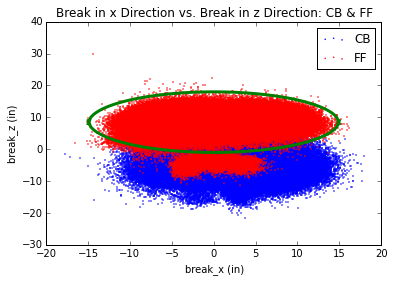

In [82]:
#create scatter plot of movement

#plot CB and FF
plt.scatter(pitchDF[pitchDF['pitch_type'] == 'CB']['break_x'].values, pitchDF[pitchDF['pitch_type'] == 'CB']\
            ['break_z'].values, s=0.3, color='blue', label = 'CB')
plt.scatter(pitchDF[pitchDF['pitch_type'] == 'FF']['break_x'].values, pitchDF[pitchDF['pitch_type'] == 'FF']\
            ['break_z'].values, s=0.3, color='red', label = 'FF')

#plot the ellipse
x_vals = np.linspace(-15,15,100)
def pos_ellipseFF(x):
    return 8 + np.sqrt((10**2)*(1-((x**2)/15.**2)))
def neg_ellipseFF(x):
    return -np.sqrt(10**2*(1-(x**2/15.**2))) + 9
y_vals1 = [pos_ellipseFF(pt)  for pt in x_vals]
y_vals2 = [neg_ellipseFF(pt) for pt in x_vals]
plt.plot(x_vals,y_vals1, color='green', linewidth=3)
plt.plot(x_vals, y_vals2, color='green', linewidth=3)
plt.title('Break in x Direction vs. Break in z Direction: CB & FF')
plt.xlabel('break_x (in)')
plt.ylabel('break_z (in)')
plt.legend()
plt.show()

To explore movement more, I created hexbin plots of *break_x* and *break_z* for fastballs (FF) and curveballs (CB). See "Break in x vs. Break in z" Again, I chose these two pitches because of their stark contrasts. Their differences were reiterated in the plots below. Handedness of the batter is again evident. This comparison will help with classification, as the densities are skewed to opposite sides. 

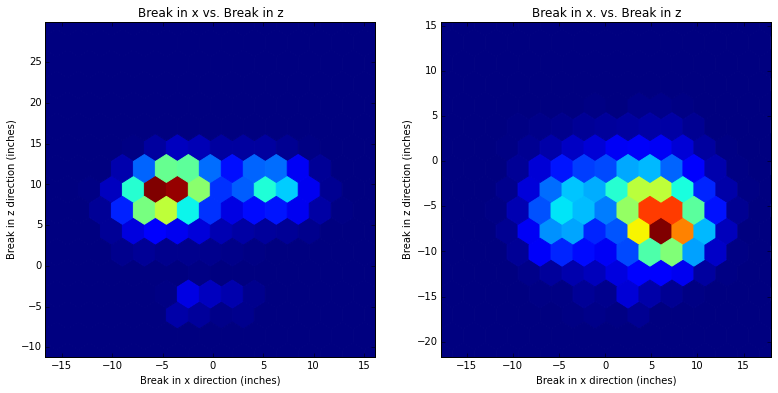

In [83]:
plt.figure(figsize = (13,6))
plt.subplot(1,2,1)
plt.hexbin(pitchDF[pitchDF['pitch_type'] == 'FF']['break_x'].values, pitchDF[pitchDF['pitch_type'] == 'FF']\
           ['break_z'].values, gridsize=15)
plt.ylabel('Break in z direction (inches)')
plt.xlabel('Break in x direction (inches)')
plt.title('Break in x vs. Break in z')

plt.subplot(1,2,2)
plt.hexbin(pitchDF[pitchDF['pitch_type'] == 'CB']['break_x'].values, pitchDF[pitchDF['pitch_type'] == 'CB']\
           ['break_z'].values, gridsize=15)
plt.ylabel('Break in z direction (inches)')
plt.xlabel('Break in x direction (inches)')
plt.title('Break in x. vs. Break in z')
plt.show()

##5    Closing Remarks

###5.1   Further Research

The Pitchf/x dataset is an incredible one. There is so much more than what was described here, and it could be used for valuable research. Some other comparisons that could potentially give information are speed vs. spin rate. This could help classify curveballs very well, as they are known for their spin rates. I would also like to explore several of the same things, but separating matchups by righty vs. righty, righty vs. lefty, and lefty vs. lefty. I think that splitting pitches up like that would not only increase the amount of data points on each graph, but could provide more intuition about where pitches are really being thrown. This way, the graphs might not be so symmetrical. Another way to tackle data visualization would be to only include fastballs, curveballs, changeups, and sliders. These are probably the four most common pitches anyway, and they all have distinct characteristics.

###5.2    Conclusion

Classification itself is an interesting problem, and I think the pitch classification problem will be interesting based on what was shown in this report. Pitchers need to have several pitches to be successful but it is not feasible to have a human record all pitches, especially with the capabilities of today's technology. Again, while location, speed, and trajectory are all important features, none of them can completely determine pitch type on their own. It is the combination of the three of them that makes it possible to classify a pitch.

Of the 16 pitch types classified by Pitchf/x, I decided to keep 14, drop two, and move a few around so that the data made more sense. Four-seam fastballs (FF) were by far the most frequent pitch thrown, followed by sliders (SL), two-seam fastballs (FT), and then changeups (CH). AB's and SC's were dropped simply because there were not enough occurences for them to be meaningful classifications. UN pitches were dropped as well so that the eventual classifier will not result in Unidentified pitches. 

Speed, position, and movement variables give nearly full information on how a pitch travels from the pitcher's hand to home plate. The constrast between eephus pitches, curveballs, and fastballs is very obvious. Break is especially telling. While speed is useful, it does not help at all to distinguish two- and four-seam fastballs. Based on this analysis, I feel confident about the data I have selected to tackle the classification problem. While I believe that the four main pitch types will be relatively easy to distinguish (fastball, curveball, slider, and changeup), I think the others will require much more effort. As mentioned before, none of them alone can classify a pitch. But, each variable tells more about the pitch, and combining them will hep to give the complete pitcture. 